In [63]:
# import cProfile
import collections
import datetime

import os
# import sys
import time

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, RobustScaler

import random

import gc

pd.options.display.float_format = "{:.2f}".format
# plt.rcParams.update({'font.size': 18})
format = '%d/%m/%Y %H:%M'

# Load data

Load all data required.

In [2]:
def load_file(data_path, msg):
    if msg != '':
        txt = msg + ' - ' + data_path
    else:
        txt = data_path

    if os.path.exists(data_path):
        print('Loaded: ' + txt)
        with open(data_path, 'rb') as f:
            file_loaded = pickle.load(f)
        return file_loaded
    else:
        print('File not found: ' + txt)

In [3]:
# Load all data

playlists_train = load_file(
    os.getcwd() + '\\data\\processed\\3_playlists_dict_train.pkl',
    'Playlists dictionary (training)')
playlists_test = load_file(
    os.getcwd() + '\\data\\processed\\3_playlists_dict_test.pkl',
    'Playlists dictionary (test)')
print('Playlist - training set: ' + str(len(playlists_train)))
print('Playlist - test set: ' + str(len(playlists_test)))
print()

tracks_dict_train = load_file(
    os.getcwd() + '\\data\\processed\\4_tracks_dict_train.pkl',
    'Tracks dictionary (training)')
tracks_dict_test = load_file(
    os.getcwd() + '\\data\\processed\\4_tracks_dict_test.pkl',
    'Tracks dictionary (test)')
print('Tracks - training set: ' + str(len(tracks_dict_train)))
print('Tracks - test set: ' + str(len(tracks_dict_test)))
print()

artists_dict_train = load_file(
    os.getcwd() + '\\data\\processed\\5_artists_dict_train.pkl',
    'Artist dictionary (training)')
artists_dict_test = load_file(
    os.getcwd() + '\\data\\processed\\5_artists_dict_test.pkl',
    'Artist dictionary (test)')
print('Artist - training set: ' + str(len(artists_dict_train)))
print('Artist - test set: ' + str(len(artists_dict_test)))
print()

albums_dict_train = load_file(
    os.getcwd() + '\\data\\processed\\6_albums_dict_train.pkl',
    'Albums dictionary (training)')
albums_dict_test = load_file(
    os.getcwd() + '\\data\\processed\\6_albums_dict_test.pkl',
    'Albums dictionary (test)')
print('Albums - training set: ' + str(len(albums_dict_train)))
print('Albums - test set: ' + str(len(albums_dict_test)))
print()

Loaded: Playlists dictionary (training) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\3_playlists_dict_train.pkl
Loaded: Playlists dictionary (test) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\3_playlists_dict_test.pkl
Playlist - training set: 1243
Playlist - test set: 533

Loaded: Tracks dictionary (training) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\4_tracks_dict_train.pkl
Loaded: Tracks dictionary (test) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\4_tracks_dict_test.pkl
Tracks - training set: 63699
Tracks - test set: 31183

Loaded: Artist dictionary (training) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\5_artists_dict_train.pkl
Loaded: Artist dictionary (test) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\5_artists_dict_test.pkl
Artist - training set: 22639
Artist - test set: 12780

Loaded: Albums dictionary

##### Create data frames to perform analysis

In [4]:
gc.collect()
df_playlists_train = playlists_train.T
print("df_playlists_train:", df_playlists_train.shape)

df_playlists_test = playlists_test.T
print("df_playlists_test:", df_playlists_test.shape)

df_tracks_train = pd.DataFrame.from_dict(tracks_dict_train, orient='index')
df_tracks_train = df_tracks_train.T
print("df_tracks_train:", df_tracks_train.shape)

df_tracks_test = pd.DataFrame.from_dict(tracks_dict_test, orient='index')
df_tracks_test = df_tracks_test.T
print("df_tracks_test:", df_tracks_test.shape)

df_artists_train = pd.DataFrame.from_dict(artists_dict_train, orient='index')
df_artists_train = df_artists_train.T
print("df_artists_train:", df_artists_train.shape)

df_artists_test = pd.DataFrame.from_dict(artists_dict_test, orient='index')
df_artists_test = df_artists_test.T
print("df_artists_test:", df_artists_test.shape)

df_albums_train = pd.DataFrame.from_dict(albums_dict_train, orient='index')
df_albums_train = df_albums_train.T
print("df_albums_train:", df_albums_train.shape)

df_albums_test = pd.DataFrame.from_dict(albums_dict_test, orient='index')
df_albums_test = df_albums_test.T
print("df_albums_test:", df_albums_test.shape)

df_playlists_train: (4, 1243)
df_playlists_test: (4, 533)
df_tracks_train: (7, 63699)
df_tracks_test: (7, 31183)
df_artists_train: (3, 22639)
df_artists_test: (3, 12780)
df_albums_train: (4, 46688)
df_albums_test: (4, 24258)


# Co-occurrence matrix

## Tracks co-occurrence matrix

In [5]:
def co_occurrence_matrix_tracks(playlists_dict, tracks_dict):
    matrix = {}
    for i, item in enumerate(tracks_dict):
        tracks_matched = []
        for j, playlist_id in enumerate(tracks_dict[item]['in_playlist']):
            for tr, track in enumerate(playlists_dict[playlist_id]['tracks']):
                tracks_matched.append(track['id'])
        counter = collections.Counter(tracks_matched)
        b = pd.DataFrame.from_dict(counter, orient='index', columns=['cnt'])
        b = b.sort_values('cnt', ascending=False)

        min_max = MinMaxScaler()
        b['count_scaled'] = min_max.fit_transform(b[['cnt']])
        b['rank'] = b['count_scaled'].rank(method='average', ascending=False)

        matrix.update({item: b})
    return (matrix)

## Artists co-occurrence matrix

In [6]:
def co_occurrence_matrix_artists(playlists_dict, artists_dict):
    matrix = {}
    for i, item in enumerate(artists_dict):
        artist_matched = []
        for j, playlist_id in enumerate(artists_dict[item]['in_playlist']):
            for tr, track in enumerate(playlists_dict[playlist_id]['tracks']):
                for a, artist in enumerate(track['artists']):
                    artist_matched.append(artist['id'])
        counter = collections.Counter(artist_matched)
        b = pd.DataFrame.from_dict(counter, orient='index', columns=['cnt'])
        b = b.sort_values('cnt', ascending=False)

        min_max = MinMaxScaler()
        b['count_scaled'] = min_max.fit_transform(b[['cnt']])
        b['rank'] = b['count_scaled'].rank(method='average', ascending=False)

        matrix.update({item: b})
    return (matrix)

## Albums co-occurrence matrix

In [7]:
def co_occurrence_matrix_albums(playlists_dict, albums_dict):
    matrix = {}
    for i, item in enumerate(albums_dict):
        albums_matched = []
        for j, playlist_id in enumerate(albums_dict[item]['in_playlist']):
            for tr, track in enumerate(playlists_dict[playlist_id]['tracks']):
                albums_matched.append(track['album']['id'])
        counter = collections.Counter(albums_matched)
        b = pd.DataFrame.from_dict(counter, orient='index', columns=['cnt'])
        b = b.sort_values('cnt', ascending=False)

        min_max = MinMaxScaler()
        b['count_scaled'] = min_max.fit_transform(b[["cnt"]])
        b["rank"] = b['count_scaled'].rank(method='average', ascending=False)

        matrix.update({item: b})
    return (matrix)

##  Create all co-ocurrence matrix

In [8]:
def co_ocurrence(playlist, df, data_path, txt):
    # check if data extraction already exists then load if it exists, otherwise run query
    if os.path.exists(data_path):
        print('Co-occurrence ' + txt + ' - Loaded: ' + data_path)
        # load file only if the next step was not executed (getting tracks)
        with open(data_path, 'rb') as f:
            co_occurrence = pickle.load(f)
    else:
        print('Co-occurrence ' + txt + ' - Saved: ' + data_path)
        # list of all user ids (UID) and playlist ids (PID)
        uid_pid_raw = []

        if txt == 'tracks':
            co_occurrence = co_occurrence_matrix_tracks(playlist, df)
        elif txt == 'artists':
            co_occurrence = co_occurrence_matrix_artists(playlist, df)
        elif txt == 'albums':
            co_occurrence = co_occurrence_matrix_albums(playlist, df)

        # Save the data
        with open(data_path, 'wb') as f:
            pickle.dump(co_occurrence, f)

    len(co_occurrence)
    # co_occurrence_tracks['1MJ5f5EYBC92ADD6xcz7nb']
    return co_occurrence

In [9]:
gc.collect()

co_occurrence_tracks_train = co_ocurrence(
    df_playlists_train, df_tracks_train,
    os.getcwd() + '\\data\\processed\\7_co_occurrence_tracks_train.pkl',
    'tracks')
co_occurrence_tracks_test = co_ocurrence(
    df_playlists_test, df_tracks_test,
    os.getcwd() + '\\data\\processed\\7_co_occurrence_tracks_train.pkl',
    'tracks')

co_occurrence_artists_train = co_ocurrence(
    df_playlists_train, df_artists_train,
    os.getcwd() + '\\data\\processed\\7_co_occurrence_artists_train.pkl',
    'artists')
co_occurrence_artists_test = co_ocurrence(
    df_playlists_test, df_artists_test,
    os.getcwd() + '\\data\\processed\\7_co_occurrence_artists_train.pkl',
    'artists')

co_occurrence_albums_train = co_ocurrence(
    df_playlists_train, df_albums_train,
    os.getcwd() + '\\data\\processed\\7_co_occurrence_albums_train.pkl',
    'albums')
co_occurrence_albums_test = co_ocurrence(
    df_playlists_test, df_albums_test,
    os.getcwd() + '\\data\\processed\\7_co_occurrence_albums_train.pkl',
    'albums')

Co-occurrence tracks - Loaded: C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\7_co_occurrence_tracks_train.pkl
Co-occurrence tracks - Loaded: C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\7_co_occurrence_tracks_train.pkl
Co-occurrence artists - Loaded: C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\7_co_occurrence_artists_train.pkl
Co-occurrence artists - Loaded: C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\7_co_occurrence_artists_train.pkl
Co-occurrence albums - Loaded: C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\7_co_occurrence_albums_train.pkl
Co-occurrence albums - Loaded: C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\7_co_occurrence_albums_train.pkl


# Model

In [10]:
def prepare_inputs(playlist_trx, trx_train, trx_test, fraction):
    trx = playlist_trx.tracks
    n = int((len(trx) + 1) * fraction)

    ids = pd.DataFrame(trx).id  # ids of the original playlist
    selected_ids = random.sample(ids.values.tolist(), n)
    expected_ids = ids[~ids.isin(ids)]

    db = trx_train.T
    trx_available = db[~db.id.isin(ids)]
    
    reference_trx = trx_test.T[trx_test.T.id.isin(selected_ids)]
    expected_trx = trx_test.T[~trx_test.T.id.isin(selected_ids)
                              & trx_test.T.id.isin(ids)]
    
    
    return trx_available, reference_trx, expected_trx

## Random

In [11]:
def get_trk_rnd(playlist_trx, trx_train, trx_test, fraction):
    trx_available, reference_trx, expected_trx = prepare_inputs(playlist_trx, trx_train, trx_test, fraction)
        
    select = random.sample(trx_available['id'].values.tolist(), len(expected_trx))
    
    selected_trx = trx_available[trx_available.id.isin(select)]

    return reference_trx, expected_trx, selected_trx


# reference_trx, expected_trx, selected_trx = get_trk_rnd(
#     df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train,
#     df_tracks_test, .5)
# print(len(reference_trx), len(expected_trx), len(selected_trx))
# reference_trx, expected_trx, selected_trx

## Ocurrence frequency

In [64]:
# Calculate the tracks frequency
def get_trx_freq(db):
    data_path = os.getcwd() + '\\data\\processed\\8_tracks_frequency.pkl'
    txt = 'Tracks frequency - ' + data_path
    if os.path.exists(data_path):
        print('Loaded: ' + txt)
        with open(data_path, 'rb') as f:
            tracks_frequency = pickle.load(f)
    else:
        tracks_frequency = pd.DataFrame(
            columns=['track_id', 'cnt', 'cum_sum', 'cum_perc'])

        for t, trk in enumerate(db):
            if t % 100 == 0:
                print("%s - %d/%d - LEN: %d" %
                      (datetime.datetime.now().strftime(format), t, len(db),
                       len(tracks_frequency)))

            df = db[trk]
            df = df[df.index != trk]
            tracks_frequency = tracks_frequency.append(
                {
                    'track_id': trk,
                    'cnt': df['cnt'].sum()
                }, ignore_index=True)

        tracks_frequency = tracks_frequency.sort_values(ascending=False,
                                                        by='cnt')
        tracks_frequency['cum_sum'] = tracks_frequency['cnt'].cumsum()
        tracks_frequency['cum_perc'] = 100 * tracks_frequency[
            'cum_sum'] / tracks_frequency['cnt'].sum()

        print('Saved: ' + txt)
        with open(data_path, 'wb') as f:
            pickle.dump(tracks_frequency, f)

        return tracks_frequency

In [51]:
b = get_trx_freq(co_occurrence_tracks_train)
# print(len(tracks_frequency))

Loaded: Tracks frequency - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\8_tracks_frequency.pkl


In [54]:
data_path = os.getcwd() + '\\data\\processed\\8_tracks_frequency.pkl'
txt = 'Tracks frequency - ' + data_path
if os.path.exists(data_path):
    print('Loaded: ' + txt)
    with open(data_path, 'rb') as f:
        c = pickle.load(f)

NoneType

In [16]:
a = tracks_frequency.groupby('cnt', group_keys=False).apply(lambda x: x.sample(frac=20/len(tracks_frequency)))
a

,track_id,cnt,cum_sum,cum_perc
58989,7I6Gp2dEZQMnsOmgdUR1c7,99,7130492,0.85
36903,6JLLacP83oixoe33bWjuCC,99,4194746,0.50
23411,2UKMqNCVsHrAYzBZMA0rxL,99,7158410,0.85
57997,2emWQWo5lOX3Kj6GfhfKVm,99,6616682,0.79
6053,0FMRupsIPaHms5eylMj0hH,99,7125047,0.85
47039,4R11u0yYoDPonNV2lFQr4E,99,4755779,0.57
8418,5msXh6qmKL96YmzItu95DV,99,6409376,0.76
53509,4fX1PGVgbxqY6NVzZqhMuz,99,5275628,0.63
16849,1Q3TP11UOqOdj2w34Jdgno,99,5826167,0.69
60375,7Fv1ofVT92zx0XNJEEmmRW,99,5698358,0.68


In [17]:
def get_trk_frq(playlist_trx, trx_train, trx_test, fraction):
    trx_available, reference_trx, expected_trx = prepare_inputs(playlist_trx, trx_train, trx_test, fraction)
        
    select = random.sample(trx_available['id'].values.tolist(), len(expected_trx))
    
    selected_trx = trx_available[trx_available.id.isin(select)]
    selected_trx = trx_available.groupby('cnt', group_keys=False).apply(lambda x: x.sample(frac=20/len(trx_available)))

    return reference_trx, expected_trx, selected_trx


# reference_trx, expected_trx, selected_trx = get_trk_rnd(
#     df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train,
#     df_tracks_test, .5)
# print(len(reference_trx), len(expected_trx), len(selected_trx))
# reference_trx, expected_trx, selected_trx

In [18]:
# db = df_tracks_train.T
# ids = pd.DataFrame(df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'].tracks).id
# a = db[~db.id.isin(ids)]
# b = a.values.tolist()

# # s = random.sample(list(a),50)
# # ids
# # type(ids)
# # db['1h4bUPnrpgn8qXGJ5dvTsu']
# # db.id
# print(len(db))
# # print(ids)
# print(type(ids))
# print(len(ids))
# print(len(a))
# print(len(b))
# # dataframe1[~dataframe1.column1.isin(common.column1)]
# # print(a.shape())
# # b

## Artist

In [19]:
def get_trk_artist(playlist_trx, trx_train, trx_test, fraction):
    trx_available, reference_trx, expected_trx = prepare_inputs(playlist_trx, trx_train, trx_test, fraction)
        
    select = random.sample(trx_available['id'].values.tolist(), len(expected_trx))
    
    selected_trx = trx_available[trx_available.id.isin(select)]

    return reference_trx, expected_trx, selected_trx


# reference_trx, expected_trx, selected_trx = get_trk_rnd(
#     df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train,
#     df_tracks_test, .5)
# print(len(reference_trx), len(expected_trx), len(selected_trx))
# reference_trx, expected_trx, selected_trx

## Album

In [20]:
def get_trk_album(playlist_trx, trx_train, trx_test, fraction):
    trx_available, reference_trx, expected_trx = prepare_inputs(playlist_trx, trx_train, trx_test, fraction)
        
    select = random.sample(trx_available['id'].values.tolist(), len(expected_trx))
    
    selected_trx = trx_available[trx_available.id.isin(select)]

    return reference_trx, expected_trx, selected_trx


# reference_trx, expected_trx, selected_trx = get_trk_rnd(
#     df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train,
#     df_tracks_test, .5)
# print(len(reference_trx), len(expected_trx), len(selected_trx))
# reference_trx, expected_trx, selected_trx

## Track

In [21]:
def get_trk_track(playlist_trx, trx_train, trx_test, fraction):
    trx_available, reference_trx, expected_trx = prepare_inputs(playlist_trx, trx_train, trx_test, fraction)
        
    select = random.sample(trx_available['id'].values.tolist(), len(expected_trx))
    
    selected_trx = trx_available[trx_available.id.isin(select)]

    return reference_trx, expected_trx, selected_trx


# reference_trx, expected_trx, selected_trx = get_trk_rnd(
#     df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train,
#     df_tracks_test, .5)
# print(len(reference_trx), len(expected_trx), len(selected_trx))
# reference_trx, expected_trx, selected_trx

# Evaluate models

In [22]:
def get_trk(method, reference, fraction):
    if method == 'random':
        reference_trx, expected_trx, selected_trx = get_trk_rnd(
            df_playlists_test[reference], df_tracks_train, df_tracks_test,
            fraction)
    elif method == 'frequency':
        reference_trx, expected_trx, selected_trx = get_trk_frq(
            df_playlists_test[reference], df_tracks_train, df_tracks_test,
            fraction)
    elif method == 'artist':
        reference_trx, expected_trx, selected_trx = get_trk_artist(
            df_playlists_test[reference], df_tracks_train, df_tracks_test,
            fraction)
    elif method == 'album':
        reference_trx, expected_trx, selected_trx = get_trk_album(
            df_playlists_test[reference], df_tracks_train, df_tracks_test,
            fraction)
    elif method == 'playlist':
        reference_trx, expected_trx, selected_trx = get_trk_track(
            df_playlists_test[reference], df_tracks_train, df_tracks_test,
            fraction)

    return reference_trx, expected_trx, selected_trx

In [23]:
methods = ['random', 'frequency', 'artist', 'album', 'playlist']
splits = [.25, .5, .75]

In [24]:
a = df_playlists_test.T
len(a)

533

In [25]:
a = df_playlists_test
results = pd.DataFrame(columns=[
    'playlist', 'method', 'frac', 'total_tracks', 'selected_tracks', 'matches',
    'error'
])
for p, playlist in enumerate(a):
    for m, method in enumerate(methods):
#         print(method)
        for f, frac in enumerate(splits):
#             print(frac)
            if m == 0:
                if p % 100 == 0 and f == 0:
                    print("%s - %d/%d - LEN: %d" % (datetime.datetime.now().strftime(format), p, len(a.T), len(results)))
                #                 if p == 0:
                #                 print(p)
                #                 print(df_playlists_test[playlist])
                #                 print(type(df_playlists_test[playlist]))
                #                 print(df_playlists_test[playlist])
                reference_trx, expected_trx, selected_trx = get_trk(
                method, playlist, frac)

                matches = len(selected_trx[selected_trx.id.isin(expected_trx.id)].id)
                total_trx = a[playlist].total_tracks
                error = 1 - matches / a[playlist].total_tracks
                sel_trx = len(selected_trx)

                results = results.append(
                {
                'playlist': playlist,
                'method': method,
                'frac': frac,
                'total_tracks': total_trx,
                'selected_tracks': sel_trx,
                'matches': matches,
                'error': error
                },
                ignore_index=True)

results.set_index('playlist', inplace=True)
# print(len(reference_trx), len(expected_trx), len(selected_trx))

08/05/2022 01:06 - 0/533 - LEN: 0
08/05/2022 01:07 - 100/533 - LEN: 300
08/05/2022 01:08 - 200/533 - LEN: 600
08/05/2022 01:09 - 300/533 - LEN: 900
08/05/2022 01:10 - 400/533 - LEN: 1200
08/05/2022 01:10 - 500/533 - LEN: 1500


In [26]:
# profiling_grid['performance_ratio'] = profiling_grid['accuracy']/profiling_grid['run_time']
# profiling_grid['run_time_mean'] = profiling_grid.groupby('classifier')['run_time'].transform('mean')
# profiling_grid['accuracy_mean'] = profiling_grid.groupby('classifier')['accuracy'].transform('mean')
# profiling_grid['performance_average'] = profiling_grid.groupby('classifier')['performance_ratio'].transform('mean')
# profiling_grid['rank_overall'] = profiling_grid['performance_ratio'].rank(method='dense', ascending=False)
# profiling_grid['rank_average'] = profiling_grid['performance_average'].rank(method='dense', ascending=False)

In [27]:
results

,method,frac,total_tracks,selected_tracks,matches,error
playlist,,,,,,
1h4bUPnrpgn8qXGJ5dvTsu,random,0.25,100,75,0,1.00
1h4bUPnrpgn8qXGJ5dvTsu,random,0.50,100,50,0,1.00
1h4bUPnrpgn8qXGJ5dvTsu,random,0.75,100,25,0,1.00
7Mht6GZuNHUvNwYMTDgB6b,random,0.25,25,19,0,1.00
7Mht6GZuNHUvNwYMTDgB6b,random,0.50,25,12,0,1.00
...,...,...,...,...,...,...
4CeyODedBm7b9bObDpkoGw,random,0.50,24,12,0,1.00
4CeyODedBm7b9bObDpkoGw,random,0.75,24,6,0,1.00
7p26YrYpOVw4wU88i23FJE,random,0.25,40,30,0,1.00


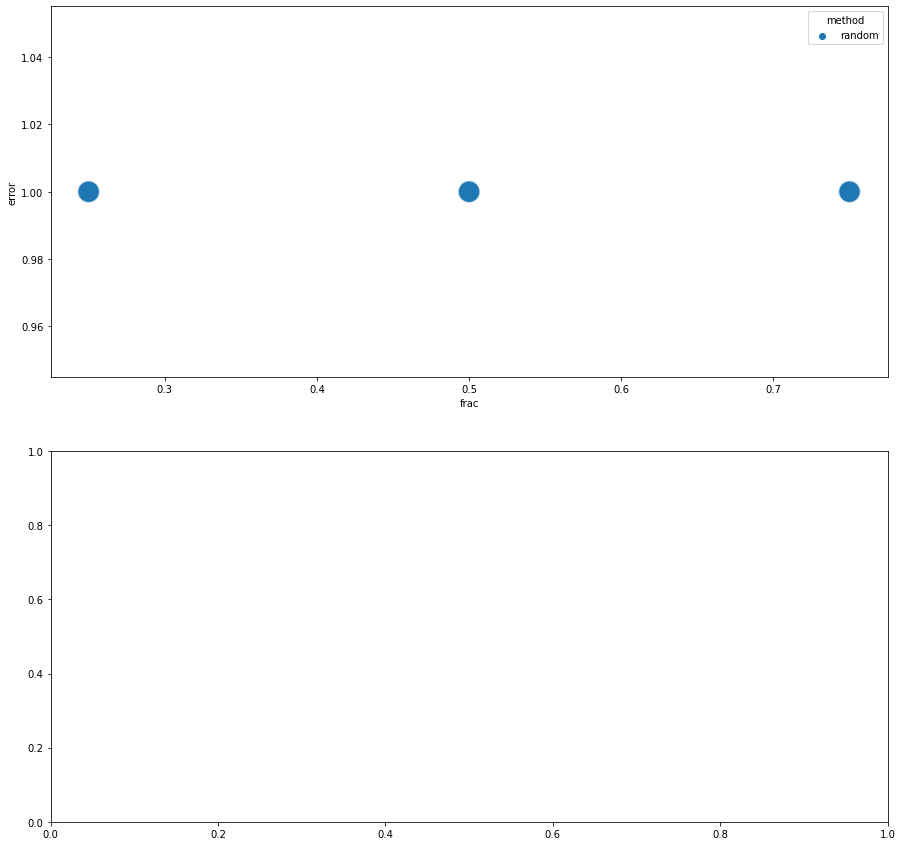

In [28]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(15, 15))
sns.scatterplot(ax=axes[0], x='frac', y='error', data=results, s=500, alpha =0.7, hue='method');
# plt.y_label('Run time') #y label

# sns.scatterplot(ax=axes[1], x='run_time_mean', y='accuracy_mean', data=profiling_grid, s=500, alpha =0.7, hue='classifier');
# plt.xlabel('Mean run time') #y label
# plt.ylabel('Mean accuracy') #x label
# plt.grid()
plt.rcParams['axes.grid'] = True

#  Tests

In [29]:
# expected_trx

In [30]:
# selected_trx

In [31]:
# # reference_trx, expected_trx, 
# selected_trx = selected_trx.append(expected_trx[expected_trx['id'] == '0e3CM2Fm4cpDtxjzYkdLAr'])

# matches = selected_trx[selected_trx.id.isin(expected_trx.id)].id
# matches
# len(matches)

In [32]:
# selected_trx.info()

In [33]:
# for t, tid in enumerate(co_occurrence_tracks_train):
#     if t == 10:
#         df = co_occurrence_tracks_train[tid]
#         df['cum_sum'] = df['cnt'].cumsum()
#         df['cum_perc'] = 100*df['cum_sum']/df['cnt'].sum()
#         selector = random.sample(list(df.index),len(df))
#         print(selector)
#         print(len(selector))

#         cnt = 0
#         tot = 0
#         for i, item in enumerate(co_occurrence_tracks_train[tid]['cnt']):
#                 cnt = cnt + 1
#                 tot = tot + item
#         print(cnt)
#         print(tot)

In [34]:
# def ranking(df,id_column):
#     single_list_temp = single_list(df[id_column])
#     data = {id_column: single_list_temp}
#     aux_df = pd.DataFrame(data)
    
#     name = id_column.replace('_id','_count')
#     ranked_sorted = aux_df.groupby([id_column]).agg(
#         temp_count=pd.NamedAgg(column=id_column, aggfunc="count")
#     )
#     ranked_sorted = ranked_sorted.rename(columns={'temp_count': name})
#     ranked_sorted = ranked_sorted.sort_values(name,ascending=False)
#     return ranked_sorted
# # ranking(df_test,'tracks_id')
# # print(tracks_rank)

# def top(ranked,n):
#     top_n = ranked.iloc[:n]
    
#     return top_n
# # tracks_rank = ranking(df_test,'tracks_id')
# # top(tracks_rank,10)
#     return ranked

# a = track_rank = ranking(df_test,'tracks_id')

In [35]:
# df['cum_sum'] = df['cnt'].cumsum()
# df['cum_perc'] = 100*df['cum_sum']/co_occurrence_tracks_train['cnt'].sum()

In [36]:
# matrix track x track
# track_rank = ranking(df_test,'tracks_id')
# s_tracks_id = list(track_rank.index)

# shape = [len(s_tracks_id), len(s_tracks_id)]
# track_matrix = np.zeros(shape, dtype=int, order='C')

# for i, row_track in enumerate(s_tracks_id):
#     row = s_tracks_id.index(row_track)
#     if i != row: print("i: " + str(i) + ": " + row_track), print()

#     for playlist in df_test['tracks_id']:
#         try:
#             check = playlist.index(row_track)
#         except ValueError:
#             #             print(row)
#             check = -1
#         if check >= 0:
#             for col_track in playlist:
#                 if col_track is not None:
#                     col = s_tracks_id.index(col_track)
#                     #                     print(col_track  + " - " + str(col))
#                     #                     tr = df_test['tracks'][n][col]
#                     #                     print("track: " + str(n) + ": " + col_track + " - col_match:" + str(col) + ": ") # + tr)
#                     track_matrix[row, col] += 1
# # print(track_matrix)